In [1]:
!date

Fri Oct 23 11:16:28 PDT 2020


# Merfish 10x comparison

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from scipy.spatial import ConvexHull
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
mfish = anndata.read_h5ad("../../data/notebook/revision/merfish.h5ad")

In [4]:
tenx = anndata.read_h5ad("../../data/notebook/revision/10xv3_gene.h5ad")

In [5]:
tenx

AnnData object with n_obs × n_vars = 94162 × 31053
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id'
    var: 'gene_name', 'gene_id', 'gene_short_name'

In [6]:
tenx = tenx[:,tenx.var.gene_short_name.isin(mfish.var.index)]

In [7]:
tenx.var.index = tenx.var.gene_short_name.values

In [8]:
tenx.obs.subclass_label.value_counts()

L5 IT          29721
Low Quality    22728
L6 CT          12807
L2/3 IT        10915
L6 IT           4445
L5/6 NP         3147
Vip             2966
Lamp5           2357
Sst             1869
L6b              554
Oligo            535
Astro            395
Pvalb            368
Sncg             348
doublet          257
Endo             187
L5 PT            161
OPC              145
Macrophage       122
L6 IT Car3        69
VLMC              55
SMC               11
Name: subclass_label, dtype: int64

In [9]:
mfish.obs.subclass.value_counts()

L2/3_IT             33757
L4/5_IT             29147
L6_CT               23878
Oligodendrocytes    19472
Astrocytes          19230
Endothelial         18183
L5_IT               14685
L6_IT               12475
Microglia            8554
Pvalb                7885
L5_PT                6759
Pericytes            6553
VLMC                 6173
Macrophages          5133
OPC                  4906
Sst                  4853
SMC                  3785
L6b                  3487
L56_NP               3482
striatum             3214
Lamp5                3095
Vip                  2789
L6_IT_Car3           1563
Sncg                  477
Sst_Chodl             232
Ependymal              32
Name: subclass, dtype: int64

# Process

In [10]:
from sklearn.preprocessing import normalize

In [11]:
tenx.layers["X"] = tenx.X
tenx.layers["norm"] = normalize(tenx.X, norm='l1', axis=1)*1000000
tenx.layers["log1p"] = csr_matrix(np.log1p(tenx.layers["norm"]))

In [12]:
from sklearn.preprocessing import scale

In [13]:
%%time
mat = tenx.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
tenx.X = mtx

CPU times: user 637 ms, sys: 388 ms, total: 1.02 s
Wall time: 1.02 s


In [14]:
del mat

# Cluster comparisons

In [15]:
tenx = tenx[:,tenx.var.sort_index().index]
mfish = mfish[:,mfish.var.sort_index().index]

In [16]:
tenx.var.head()

,gene_name,gene_id,gene_short_name
1700022I11Rik,1700022I11Rik_ENSMUSG00000028451,ENSMUSG00000028451,1700022I11Rik
1810046K07Rik,1810046K07Rik_ENSMUSG00000036027,ENSMUSG00000036027,1810046K07Rik
5031425F14Rik,5031425F14Rik_ENSMUSG00000085129,ENSMUSG00000085129,5031425F14Rik
5730522E02Rik,5730522E02Rik_ENSMUSG00000032985,ENSMUSG00000032985,5730522E02Rik
Acta2,Acta2_ENSMUSG00000035783,ENSMUSG00000035783,Acta2


In [17]:
mfish.var.head()

,n_iso
index,
1700022I11Rik,5
1810046K07Rik,2
5031425F14Rik,1
5730522E02Rik,8
Acta2,1


In [18]:
unique_map = {
"L5_IT" : "L5 IT",
"L6_CT" : "L6 CT",
"L6b" : "L6b",
"Vip" : "Vip",
"Pvalb" : "Pvalb",
"L2/3_IT" : "L2/3 IT",
"L6_IT" : "L6 IT",
"Sst" : "Sst",
"Lamp5" : "Lamp5",
"L56_NP" : "L5/6 NP",
"Sncg" : "Sncg",
"SMC" : "SMC",
"L5_PT" : "L5 PT", # Check
"Endothelial" : "Endo",
"Astrocytes" : "Astro",
"VLMC" : "VLMC",
"L6_IT_Car3" : "L6 IT Car3"}

inv_map = {v: k for k, v in unique_map.items()}

In [19]:
def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((nuniq, mtx.shape[1]))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        #print(source_indices)
        
        # breaks generality
        sub_mtx = mtx[source_indices,:].mean(axis=0) # Sum on source indicies
        X[tidx,:] = sub_mtx # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)

In [20]:
tenx = tenx[tenx.obs.subclass_label!="Low Quality"]
mfish.obs["tenx_subclass"] = mfish.obs["subclass"].apply(lambda x: unique_map.get(x, "None"))
mfish = mfish[mfish.obs.tenx_subclass != "None"]

Trying to set attribute `.obs` of view, copying.


In [21]:
mfish_mat = mfish.X
mfish_ass = mfish.obs.tenx_subclass.values

In [22]:
tenx_mat = tenx.X
tenx_ass = tenx.obs.subclass_label.values

In [23]:
tenx

View of AnnData object with n_obs × n_vars = 71434 × 254
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id'
    var: 'gene_name', 'gene_id', 'gene_short_name'
    layers: 'X', 'norm', 'log1p'

In [24]:
features = mfish.var.index.values

unique = np.intersect1d(np.unique(mfish_ass), np.unique(tenx_ass))

In [25]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [26]:
from scipy import stats

In [27]:
%%time
r2 = []
tenx_x = []
mfish_x = []

for uidx, u in enumerate(unique):
    mfish_t_mat, _ = split_by_target(mfish_mat, mfish_ass, u)
    tenx_t_mat, _ = split_by_target(tenx_mat, tenx_ass, u)
    
    
    mf = np.asarray(mfish_t_mat.mean(axis=0)).reshape(-1)
    t = np.asarray(tenx_t_mat.mean(axis=0)).reshape(-1)
    
    tenx_x.append(t)
    mfish_x.append(mf)
    
    r, p = stats.pearsonr(mf, t)
    r2.append(r)
    print("[{} of {}] {:,.2f}: {}".format(uidx+1, unique.shape[0],r, u) )

[1 of 17] 0.71: Astro
[2 of 17] 0.72: Endo
[3 of 17] 0.78: L2/3 IT
[4 of 17] 0.36: L5 IT
[5 of 17] 0.76: L5 PT
[6 of 17] 0.84: L5/6 NP
[7 of 17] 0.82: L6 CT
[8 of 17] 0.77: L6 IT
[9 of 17] 0.80: L6 IT Car3
[10 of 17] 0.86: L6b
[11 of 17] 0.89: Lamp5
[12 of 17] 0.75: Pvalb
[13 of 17] 0.59: SMC
[14 of 17] 0.79: Sncg
[15 of 17] 0.77: Sst
[16 of 17] 0.33: VLMC
[17 of 17] 0.85: Vip
CPU times: user 1.04 s, sys: 1.08 s, total: 2.12 s
Wall time: 2.13 s


In [28]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [29]:
tenx_size = tenx.obs["subclass_label"].value_counts()[unique]

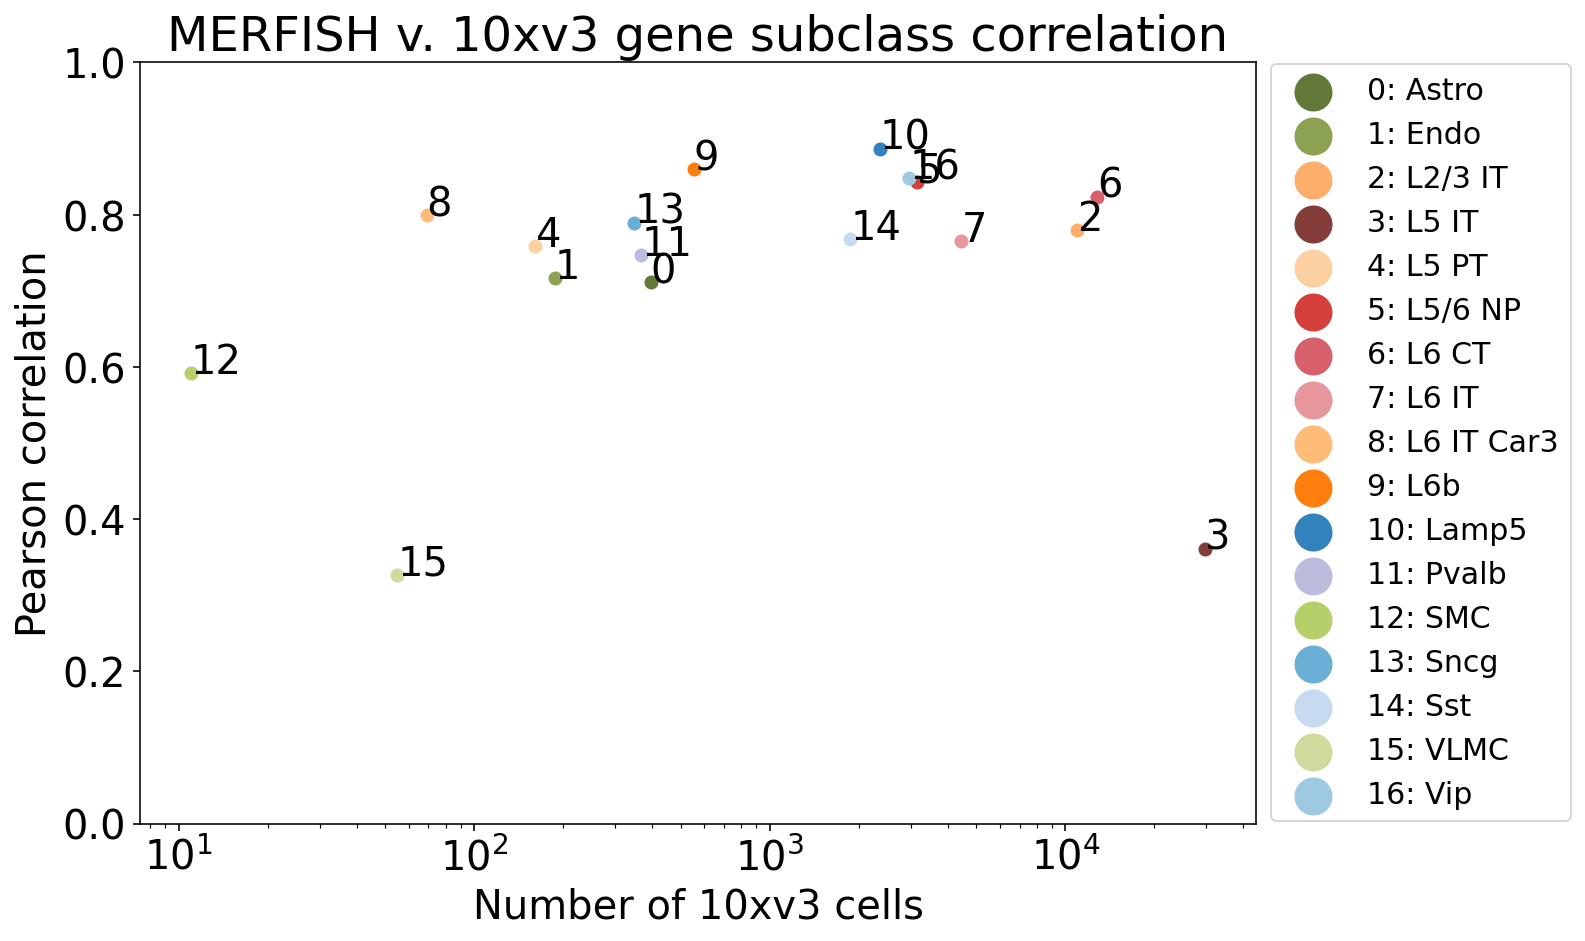

In [30]:
fig, ax = plt.subplots(figsize=(10,7))

x = tenx_size
y = r2

for i, txt in enumerate(unique):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt), color=cluster_cmap[txt])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of 10xv3 cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
ax.set_title("MERFISH v. 10xv3 gene subclass correlation")
plt.savefig("../../figures/merfish_10x_gene_subclass_size.png", bbox_inches='tight', dpi=300)
plt.show()

In [31]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

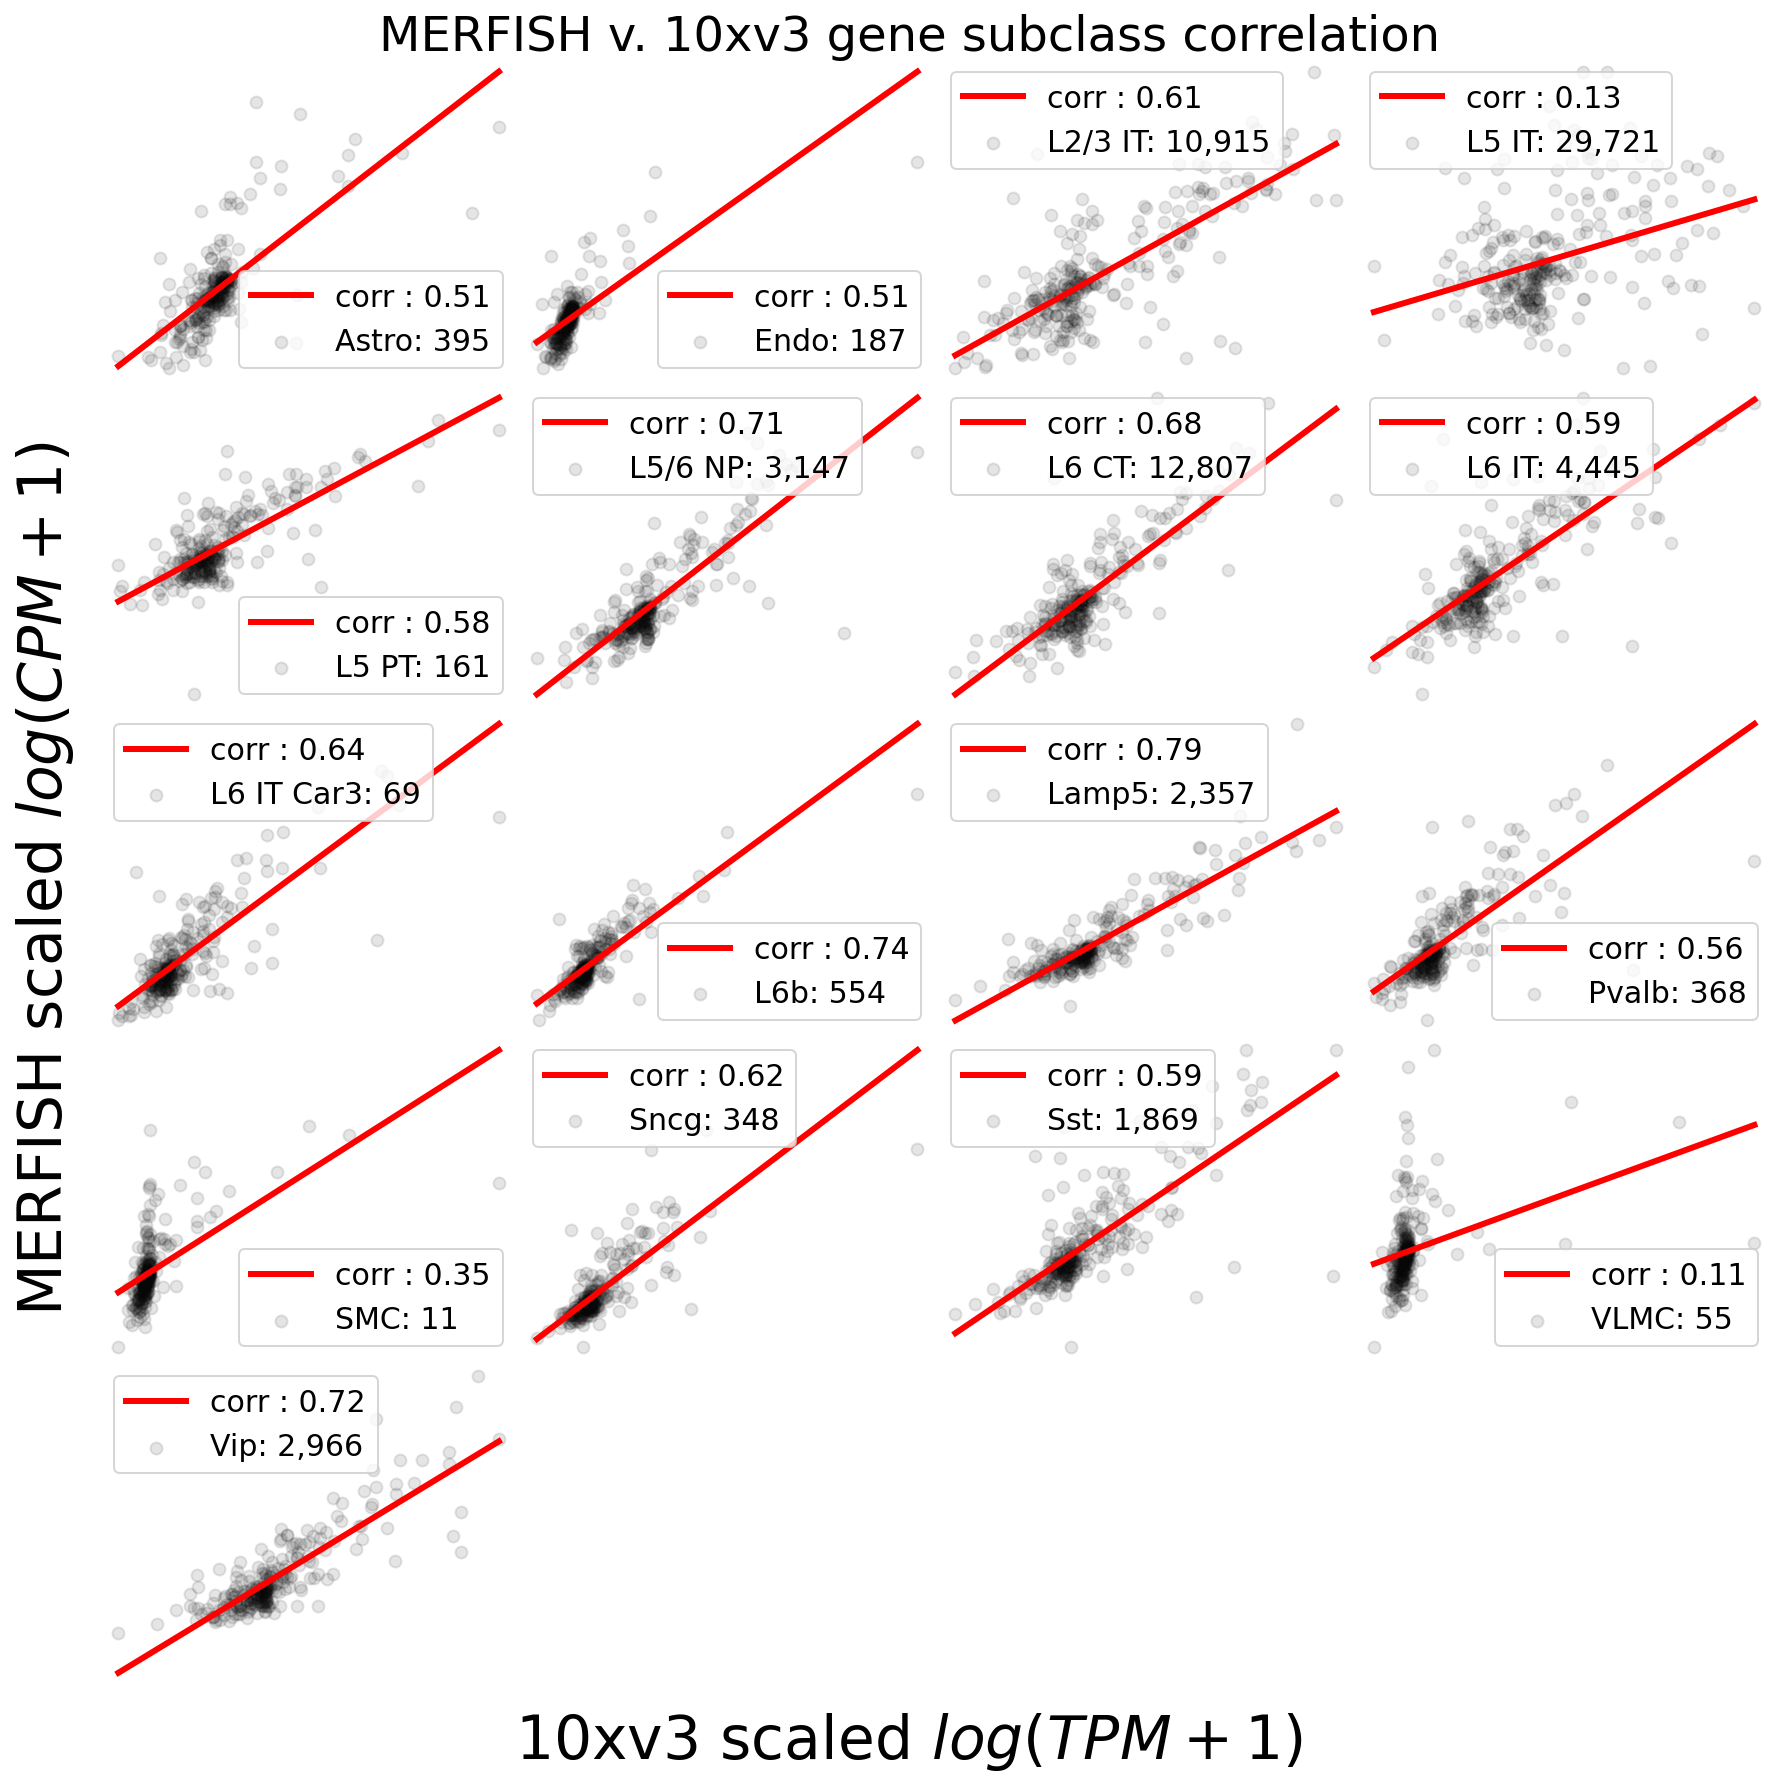

In [32]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=5)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(unique))
fig.suptitle('MERFISH v. 10xv3 gene subclass correlation', y=0.9)
#fig.subplots_adjust(top=1)

for cidx, (ax, c) in enumerate(zip(axs, unique)):
    
    
    x = tenx_x[cidx]
    y = mfish_x[cidx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, tenx_size[cidx]), color="k", alpha=0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="corr : {:,.2f}".format(r_value**2), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
fig.text(0.5, 0.1, '10xv3 scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, 'MERFISH scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)

plt.savefig("../../figures/merfish_10x_gene_subclass_correlation_scatter.png", bbox_inches='tight',dpi=300)
plt.show()

In [33]:
tenx[tenx.obs.subclass_label=="L5 IT"].obs.cluster_label.value_counts()

L5 IT Tcap_2    17334
L5 IT Tcap_1     7462
L5 IT S100b      4272
L5 IT Pld5        653
Name: cluster_label, dtype: int64

In [34]:
mfish[mfish.obs.subclass=="L5_IT"].obs.label.value_counts()

L5_IT_1    6398
L5_IT_2    4346
L5_IT_3    3941
Name: label, dtype: int64

In [35]:
mfish

View of AnnData object with n_obs × n_vars = 166556 × 254
    obs: 'label', 'subclass', 'sampleID', 'sliceID', 'label_v1', 'AP_distance (um)', 'pos_x (um)', 'pos_y (um)', 'cell_id', 'tenx_subclass'
    var: 'n_iso'
    layers: 'X', 'log1p', 'norm'